In [1]:
import scipy.io
from matplotlib import pyplot as plt
import numpy as np

In [2]:
bat = scipy.io.loadmat('Synthetic_LiPo_PulseDischarge.mat')

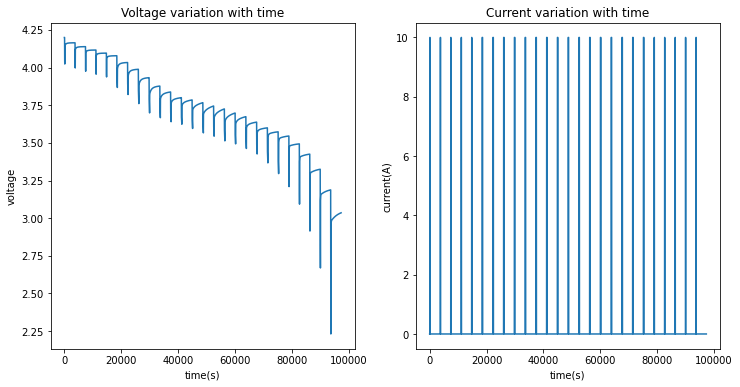

In [3]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.plot(bat['time'][:], bat['voltage'][:])
plt.title("Voltage variation with time")
plt.xlabel("time(s)")
plt.ylabel("voltage")

plt.subplot(1,2,2)
plt.plot(bat['time'][:], bat['current'][:])
plt.title("Current variation with time")
plt.xlabel("time(s)")
plt.ylabel("current(A)")
plt.savefig("Current_Discharge_pulse.png")

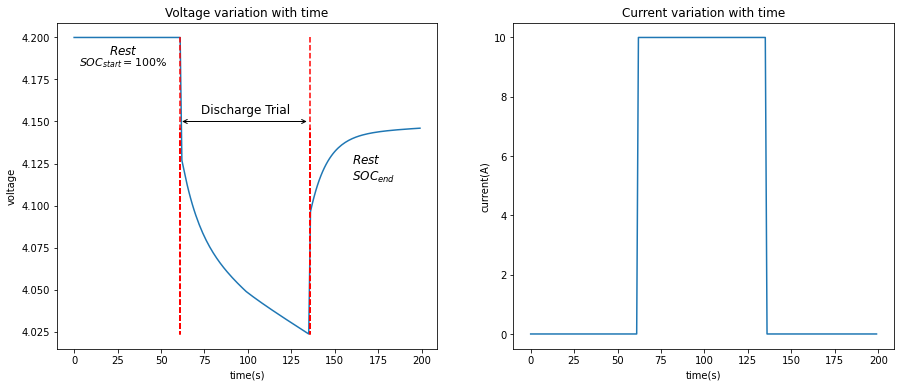

In [4]:
plt.figure(figsize = (15,6))
plt.subplot(1,2,1)
plt.plot(bat['time'][0:200], bat['voltage'][0:200])
plt.plot(61*np.ones(200), bat['voltage'][0:200], '--r')
plt.plot(136*np.ones(200), bat['voltage'][0:200], '--r')
plt.title("Voltage variation with time")
plt.xlabel("time(s)")
plt.ylabel("voltage")
plt.text(20, 4.19, '$Rest$', fontsize = 12)
plt.text(3, 4.183, '$SOC_{start} = 100\% $', fontsize = 11)
plt.text(160, 4.125, r'${Rest}$', fontsize = 12)
plt.text(160, 4.115, '$SOC_{end}$', fontsize = 12)
plt.annotate('', xy=(61,4.15), xytext=(135,4.15), arrowprops=dict(arrowstyle='<->'))
plt.text(73, 4.155, 'Discharge Trial', fontsize = 12)


plt.subplot(1, 2, 2)
plt.plot(bat['time'][0:200], bat['current'][0:200])
plt.title("Current variation with time")
plt.xlabel("time(s)")
plt.ylabel("current(A)")
plt.savefig("1_discharge_pulse.png")

### Gaussian Process Regression
#### Project Goal
We are trying to predict the Open Circuit Voltage given a current value.
$$V_{pred} = E_m - I R_0 - (I R_1 (1 - exp(-t/(R_1 C_1)))) \tag{1 RC loop}$$
here, $E_m$, $R_0$, $R_1$ and $C_1$ are the parameters for our model and $I$ and $t$ are the inputs

#### 1) Motivation
Suppose you have some data points which has some inputs x and some measured values associated with those inputs y and we are asked to make a best guess for a data point. This is non-linear regression which involves fitting curves(non-linear curve) that goes close through the data point that allows us to make prediction.We would not only return the best estimate but also the error bars around it, i.e., how confident I am in the estimate. We can solve this problem of non-linear regression with error bars with just plain old Gaussian distribution.

Regression is a common machine learning task which takes some observed datapoints, find a function that represents the dataset as closely as possible and then use that function to make predictions at new data points. It is possible for more than one polynomial to fit that observed data points. Along with making predictions we also want to measure the certainity of those predictions. GP can be used to make predictions at new data points and tell us how certain these predictions are.

#### 2) What is Gaussian Distribution
A random variable $X$ is said to be normally distributed with mean $\mu$ and variance $\sigma^2$ if its probability density function (PDF) is given by:-
\begin{equation}
    P_X(x) = \frac{1}{\sqrt{2\pi}\sigma}exp\left(-\frac{(x-\mu)^2}{2\sigma^2} \right)
\end{equation}
here $X$ represents random varibales and $x$ is the real arguement. The Gaussian or normal distribution of $X$ is usually represented by $P(x) ~ \mathcal{N}(\mu, \sigma^2)$

$$p(y \mid \Sigma) \propto ep(-\frac{1}{2} y^T \Sigma^{-1}y)$$
here, lets assume $\Sigma = \begin{bmatrix} 1 & 0.7 \\ 0.7 & 1 \end{bmatrix}$

1 D Gaussian with n random sample points from a 1-D Gaussian distribution on x axis

In [5]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sea   #statistical data visualisation library
from scipy.stats import norm

In [6]:
import warnings
warnings.filterwarnings("ignore")

<AxesSubplot:>

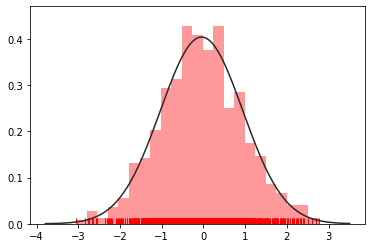

In [7]:
np.random.seed(0)

# Data Points
n = 1           # no. of independent gaussian, since here we want to plot 1-D, therefore n = 1
m = 1000        # no. of points in 1-D Gaussian 

f_random = np.random.normal(size = (n, m))

sea.distplot(f_random, hist = True, rug = True, fit = norm, kde = False, color = 'r', vertical = False)
#sea.displot(f_random, color = 'r')

1000 normally distributed data points were plotted as red vertical bars on x axis. The PDF is plotted as a two dimensionalbell curve.

<AxesSubplot:ylabel='Density'>

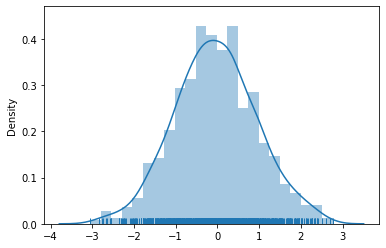

In [8]:
np.random.seed(0)

# Data Points
n = 1           # no. of independent gaussian, since here we want to plot 1-D, therefore n = 1
m = 1000        # no. of points in 1-D Gaussian 

f_random = np.random.normal(size = (n, m))

sea.distplot(f_random, hist = True, rug = True)
#sea.displot(f_random, color = 'r')

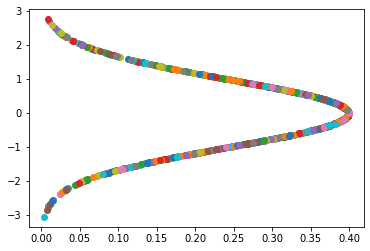

In [9]:
pdf = lambda x: 1/((2*np.pi)**(0.5)) * np.exp(-x**(2)/2)

P_x = np.zeros((n, m))
for i in range(m):
    P_x[0, i] = pdf(f_random[0, i])

plt.plot(P_x, f_random, '-o')

Here we have generated data points that follow the normal distribution. These random generated data points can be expressed as vectors $x_1 = [x_1^1, x_1^2, ..., x_1^n]$.
On the other hand, we can model data points

Now, we project all the points $[x^{(1)}, x^{(2)},...,x^{(n)}]$ on the x-axis to another space. In this space, we treat all the points $[x^{(1)}, x^{(2)},...,x^{(n)}]$ as vector $X_1$ and plot $X_1$ on the new $X$ axis at $X = 0$.

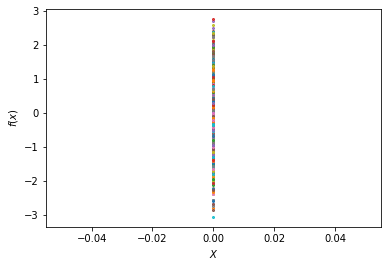

In [10]:
Xshow = np.linspace(0, 1, n).reshape(-1,1)

plt.clf()
plt.plot(Xshow, f_random, 'o', linewidth = 1, markersize = 1, markeredgewidth  =2)
plt.xlabel('$X$')
plt.ylabel('$f(x)$')
plt.show()

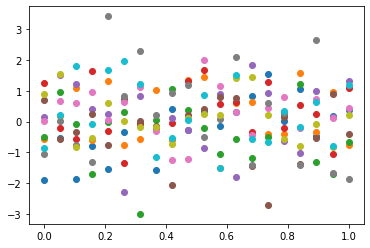

In [17]:
n = 20    # number of independent Gaussian
m = 10

f_random_2 = np.random.normal(size = (n, m))

Xshow = np.linspace(0,1,n).reshape(-1, 1)

plt.plot(Xshow, f_random_2, 'o')

Both vector $X_1$ and $X_2$ are Gaussian. In the above, we genereate 10 random points for each independent gaussian and join them using lines. These lines look like functions for each pair of points. On the other hand, plot looks like we are sampling in the region $[0, 1]$ with 10 linear functions. $[0, 1]$ domain is out region of interest, we do are regression in this region. Here we have 20 independent gaussian and these are connected by lines. These look a lot noisy. If $X$ is our input space, these functions are meaningless for regression task. We cannot do any predictions using these functions. The functions should be smoother, meaning input points that are close to each other should have similar values of the function.

Thus, functions by connecting independent gaussian are not proper for regression, we need Gaussians that are correlated to each other. So we explore Multivariable Gaussian.

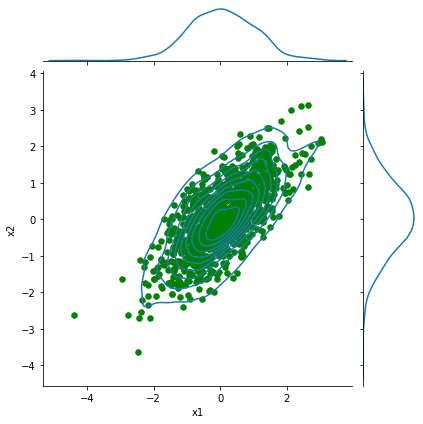

In [12]:
import pandas as pd
import seaborn as sns

cov = np.array([[1, 0.7], [0.7, 1]])
mean = np.array([0, 0])

data = np.random.multivariate_normal(mean, cov, 1000)     # mean has to be 1D array: shape->(n,)
df = pd.DataFrame(data, columns=["x1", "x2"])             # Gives a tabulated data with labeled columns and rows dictionary like container

g = sns.jointplot('x1', 'x2', data = df, kind = "kde")

g.plot_joint(plt.scatter, c = "g", s = 30)

### Kernels

It is used to smooth the sampling functions by defining covariance functions. Considering the fact that when two vectors are similar. their dot porduct output value is high, as theta = 0 or 180 and dot product is given by $A.B = AB cos\theta$, which is maximum when $cos\theta$ is $2n\pi$.

A popular covariance function(Kernel function) is squared exponential kernal, also called the radial bassis function(RBF) or Gaussian Kernel.

$$cov(x_i, x_j) = exp\left( - \frac{(x_i - x_j)^2}{2} \right)$$

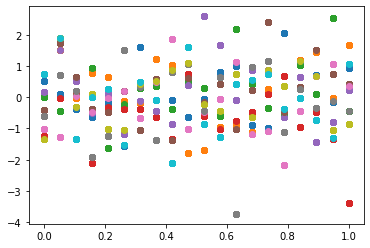

In [18]:
n = 20    # 20 independent Gaussian
m = 10    # number of data points per gaussian

mean = np.zeros(n)   # for every gaussian 1 mean
cov = np.eye(n)      # for every gaussian, correlation with other gaussian and their variance

f_prior = np.random.multivariate_normal(mean, cov, m).T

xshow = np.linspace(0, 1, n).reshape(-1, 1)  #n number of test points in the range of (0,1 )

for i in range(m):
    plt.plot(xshow, f_prior, 'o')

In [19]:
f_prior.shape

(20, 10)

We got exactly the same plot as above. Not lets apply kernel over the functions shown in the plot

In [27]:
# Define the kernel

def kernel(a, b):
    
    size = a.shape[0]
    K = np.zeros((size, size))
    
    for i in range(size):
        for j in range(size):
            sq_dist = (a[i] - b[j])**2
            K[i, j] = np.exp(-0.5*sq_dist)
    
    return K
    

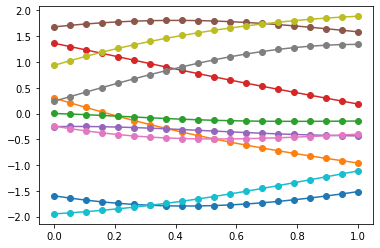

In [32]:
n = 20     # no. of independent gaussian
m = 10     # no. of points in a gaussian => no. of functions # no. of samples

x_show = np.linspace(0, 1, n).reshape(-1, 1)    # np. of test points in range [0, 1]

mean = np.zeros(n)
cov = np.eye(n)
K_ = kernel(x_show, x_show)
f_prior = np.random.multivariate_normal(mean, K_, m)

for i in range(m):
    plt.plot(x_show, f_prior[i, :], '-o')


As can be seen, we get a smoother curve compared to the previous one.

In [39]:

y_1 = np.linspace(-5, 5, 100)
y_2 = np.linspace(-5, 5, 100)
p = []
y_ = []
count = 0
for i in range(len(y_1)):
    for j in range(len(y_1)):
        #if y_1[i]**2 / 2 + y_2[j]**2 / 3 == 4 :
        y = np.array([[y_1[i]], [y_2[j]]])
        dummy = np.exp(-0.5*y.T @ Cov @ y)
        p.append(dummy)
        y_.append(y)

P_distribution = np.array(p)
P_d = np.reshape(P_distribution, (len(P_distribution)))
y_dummy = np.array(y_)
y_data = np.squeeze(y_dummy)

NameError: name 'Cov' is not defined

In [40]:
from mpl_toolkits import mplot3d

NameError: name 'y_data' is not defined

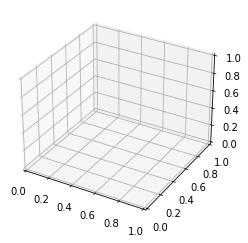

In [41]:
fig  = plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(y_data[:, 0], y_data[:, 1], P_d)

In [ ]:
plt.plot(y_data[:,0], P_d)

In [36]:
y_data

NameError: name 'y_data' is not defined